# Fisher KPP on bounded domain in 1D (PINN and SPINN)

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\frac{\partial^2}{\partial x^2} u(t,x) + u(t,x)(r(x) - \gamma(x)u(t,x)), t\geq 0, x\in [0,l]\\
\begin{cases}
u(t,0)=u(t,l)=0,t\geq 0, \text{Dirichlet condition}\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\{0,l\}}=\frac{\partial}{\partial x} u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},
\end{cases}\\
u(0,x)=u_0(x),x\in [0,l]
\end{cases}
$$

In all that follows, $r(x)$, $\gamma(x)$ et $D$ are considered constant.

__Note :__ Neumann boundary condition [wiki](https://en.wikipedia.org/wiki/Neumann_boundary_condition) fixes the value of the derivative on the boundary points. $0$ means that there is no flux through the boundary.

Les expériences de référence associées sont donc (III.29), (IV.3) ou (III.43) du livre _Modèles de réaction-diffusion pour l'écologie spatiale_ par Lionel Roques.

Different kinds of solutions are expected:

- For bounded $\Omega$, eg: $x\in[0, l]$:

  - Population persists if $\lambda_1 < 0$

  - Population goes extinct if $\lambda_1 > 0$
with
$$
\begin{cases}
\lambda_1=\frac{\pi^2}{l^2}D - r,\text{ for Dirichlet boundary condition}\\
\lambda_1=-r, \text{ for Neumann boundary condition},
\end{cases}
$$

$\lambda_1$ is the main eigenvalue of the linear elliptical operator associated with the modele.

- For unbounded $\Omega$, eg: $x\in\mathbb{R}$:
  - We can have wavefront-like solutions: see the other Fisher KPP notebook
 
**Note**: To solve the PDE, we use both a classical PINN and a [Separable PINN](https://openreview.net/pdf?id=dEySGIcDnI) approach implemented in jinns. We see that, without any specific tuning the SPINN offers an important gain in speed and precision of the solution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns

2024-09-13 16:20:20.480999: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


Create the neural network architecture for the PINN

In [5]:
eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
u_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

Create the SPINN

In [6]:
d = 2
r = 256
eqx_list = [
    [eqx.nn.Linear, 1, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, r],
]
key, subkey = random.split(key)
u_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

In [7]:
init_nn_params_pinn = u_pinn.init_params()
init_nn_params_spinn = u_spinn.init_params()

Create a DataGenerator object

In [8]:
n = 1000
nb = 2
nt = 1000
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 2
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 5
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    nt=nt,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    temporal_batch_size=temporal_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
)



Note the `cartesian_product=False` in the cell below, which tells the `train_data_spinn` DataGenerator not to output cartesian product of space and time collocation points. It is because we use a separable PINN (SPINN) which already does similar operations internally (more precisely, outer products of each axis-dimension). 

In [9]:
key, subkey = random.split(key)
train_data_spinn = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    nt=nt,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    temporal_batch_size=temporal_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    cartesian_product=False,
)


## Set up the initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

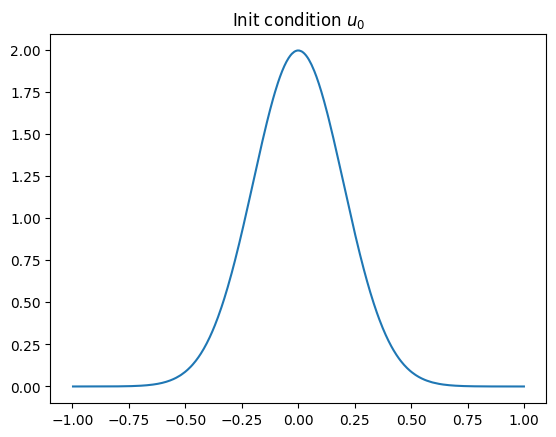

In [10]:
from jax.scipy.stats import norm
# true solution N(0,1)
sigma_init = 0.2 * jnp.ones((1))
mu_init = 0 * jnp.ones((1))

def u0(x):
    return jnp.squeeze(norm.pdf(x, loc=mu_init, scale=sigma_init))

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Model parameters

In [11]:
# Example III.29 is persistent with D = 1, r = 4,  g = 3
D = 1.
r = 4.
g = 3.
l = xmax - xmin

boundary_condition = "dirichlet"

if boundary_condition == "dirichlet":
    lambda_1 = jnp.pi ** 2 / l ** 2 * D - r
    omega_boundary_fun = lambda t, dx: 0 # cte func returning 0

elif boundary_condition == "neumann":
    lambda_1 = -r
    omega_boundary_fun = lambda t, dx: 0 # cte func returning 0

print("lambda_1 value:", lambda_1)

if lambda_1 < 0:
    # NOTE that if lambda_1 is just slightly negative the problem
    # is harder and the PINN might fall in extinction
    print("Persistance of the population is expected")
elif lambda_1 > 0:
    print("Extinction of the population is expected")


lambda_1 value: -1.5325988997276605
Persistance of the population is expected


A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [31]:


init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "D":jnp.array([D]),
        "r":jnp.array([r]),
        "g":jnp.array([g])
    }
)
init_params_spinn = jinns.parameters.Params(
    nn_params=init_nn_params_spinn,
    eq_params= {
        "D":jnp.array([D]),
        "r":jnp.array([r]),
        "g":jnp.array([g])
    }
)

## Loss construction

In [13]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax
)


In [14]:
fisher_dynamic_loss.evaluate(
    jnp.zeros((1,)),
    jnp.ones((dim)),
    u_pinn,
    init_params_pinn)

Array([-5.707223], dtype=float32)

Loss for the PINN

In [15]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1 * Tmax, boundary_loss=3 / 4 * Tmax
)

loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=boundary_condition,
    initial_condition_fun=u0,
)

Loss for the SPINN

In [16]:
loss_weights_spinn = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1 * Tmax, boundary_loss=1 * Tmax
)

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights_spinn,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=boundary_condition,
    initial_condition_fun=u0,
)

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

### Train the PINN and plot loss values and solution

In [17]:
params_pinn = init_params_pinn
# Optimizer
import optax
tx = optax.adamw(learning_rate=1e-4)
n_iter = 30000
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _, _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
)

[train] Iteration 0: loss value = 43.93737030029297
[train] Iteration 1000: loss value = 12.389764785766602
[train] Iteration 2000: loss value = 9.604480743408203
[train] Iteration 3000: loss value = 6.760564804077148
[train] Iteration 4000: loss value = 5.392345428466797
[train] Iteration 5000: loss value = 3.504023313522339
[train] Iteration 6000: loss value = 3.147624969482422
[train] Iteration 7000: loss value = 1.7988779544830322
[train] Iteration 8000: loss value = 1.58636474609375
[train] Iteration 9000: loss value = 1.0349010229110718
[train] Iteration 10000: loss value = 2.1117005348205566
[train] Iteration 11000: loss value = 1.8829768896102905
[train] Iteration 12000: loss value = 1.8692407608032227
[train] Iteration 13000: loss value = 1.5387346744537354
[train] Iteration 14000: loss value = 1.9836993217468262
[train] Iteration 15000: loss value = 1.8208624124526978
[train] Iteration 16000: loss value = 1.6163780689239502
[train] Iteration 17000: loss value = 1.894242405891

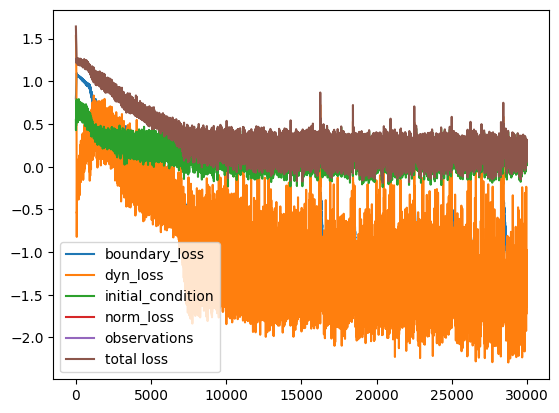

In [19]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

In [20]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

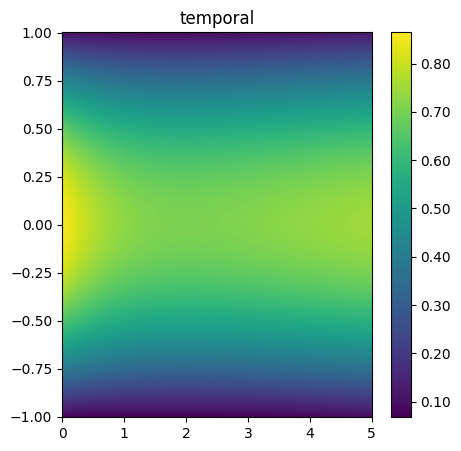

In [25]:
u_est_pinn = lambda t, x: u_pinn(t, x, params_pinn)
# same subkey
jinns.plot.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(5, 5), title="temporal")

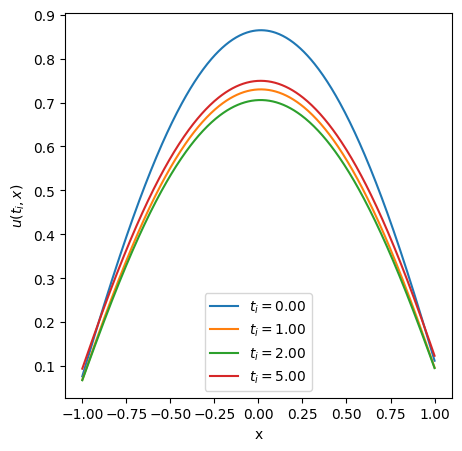

In [26]:
time_slices = [0, 0.2, 0.4, 1]
jinns.plot.plot1d_slice(u_est_pinn, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax, figsize=(5, 5))

### Train the SPINN and plot loss values and solution

In [32]:
params_spinn = init_params_spinn
tx = optax.adamw(learning_rate=1e-4)
n_iter = 30000
params_spinn, total_loss_list_spinn, loss_by_term_dict_spinn, _, _, _, _ , _, _ = jinns.solve(
    init_params=params_spinn,
    data=train_data_spinn,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter
)

[train] Iteration 0: loss value = 3.4775032997131348
[train] Iteration 1000: loss value = 1.7708532810211182
[train] Iteration 2000: loss value = 1.0695078372955322
[train] Iteration 3000: loss value = 1.2724770307540894
[train] Iteration 4000: loss value = 1.360623836517334
[train] Iteration 5000: loss value = 1.38376784324646
[train] Iteration 6000: loss value = 1.511418104171753
[train] Iteration 7000: loss value = 1.2839897871017456
[train] Iteration 8000: loss value = 1.2765650749206543
[train] Iteration 9000: loss value = 1.5528346300125122
[train] Iteration 10000: loss value = 1.503157138824463
[train] Iteration 11000: loss value = 1.1339526176452637
[train] Iteration 12000: loss value = 1.0678116083145142
[train] Iteration 13000: loss value = 1.0891153812408447
[train] Iteration 14000: loss value = 0.934565007686615
[train] Iteration 15000: loss value = 0.6949257850646973
[train] Iteration 16000: loss value = 0.9189438819885254
[train] Iteration 17000: loss value = 0.9347553849

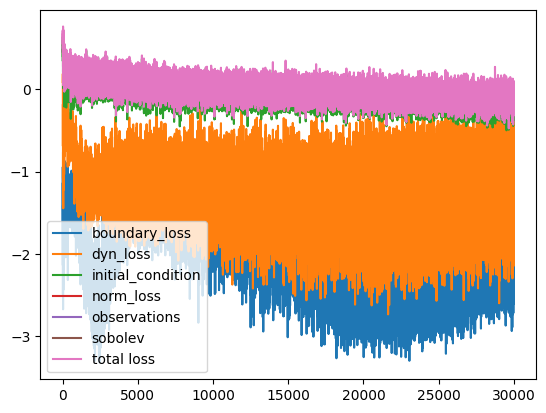

In [ ]:
for loss_name, loss_values in loss_by_term_dict_spinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_spinn), label="total loss")
plt.legend()
plt.show()

Plot the solution learned by the PINN

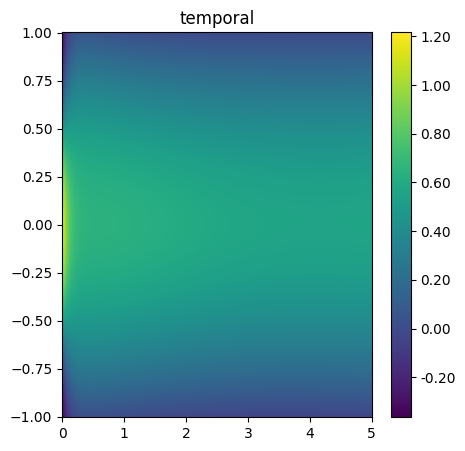

In [ ]:
u_est_spinn = lambda t, x: u_spinn(t, x, params_spinn["nn_params"])
# same subkey
jinns.plot.plot1d_image(u_est_spinn, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(5, 5), title="temporal", spinn=True)

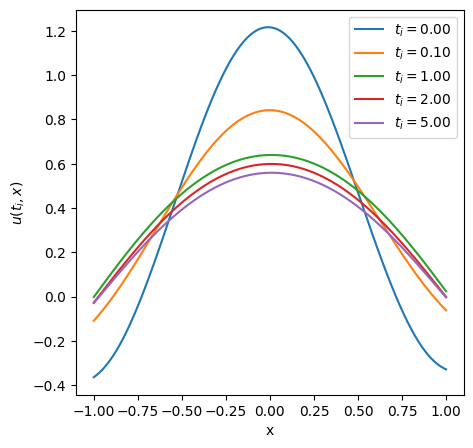

In [ ]:
time_slices = [0, 0.02, 0.2, 0.4, 1]
jinns.plot.plot1d_slice(u_est_spinn, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax, figsize=(5, 5), spinn=True)

## Conclusion

Solving this particular Fisher KPP has been possible without any specific fine-tuning with the SPINN while the PINN architecture seems tricky to tune. Moreover, the SPINN learning is ~2 times faster:

- PINN's progress bar: 30000/30000 [01:08<00:00, 433.54it/s]
 
- SPINN's progress bar:   30000/30000 [00:29<00:00, 1012.64it/s]

(Times obtained on GPU Nvidia T600)

## Compare with the analytical solution
See Fig III.1 p 73 of the book _Modèles de réaction-diffusion pour l'écologie spatiale_ by Lionel Roques. Our estimation seems good. Note that we have a slightly different Gaussian initial condition as the book does not explicit their choice for `u0`.